# Relax Inc Challenge

![adopt](images/adopted_users.jpeg)

Companies invest huge amount of money and efforts in technologies, but this would not be profitable if users are not using the tech. The biggest barrier to user adoption is keeping users being attracted to the developed tools that the company has provided. 

In this project, I analyzed the pattern of data regarding to the adoption rate, and built a model to predict the adoption rate from user's information.

# Import packages and define functions

In [66]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from datetime import timedelta

from statsmodels.stats.outliers_influence import variance_inflation_factor

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle 

import shap

#import plotly

%matplotlib inline 

sns.set_style('ticks', rc={'xtick.direction':'in', 'ytick.direction':'in', \
                           'xtick.top':True, 'ytick.right':True})

# Dataset loading and wrangling

In [88]:
datadir    = '../datasets/raw'
datadir_pr = '../datasets/processed'  # directory where the cleaned datasets are stored
figdir     = '../output/figures'

## data description

**takehome_users**
- name: the user's name
- object_id: the user's id
- email: email address
- creation_source: how their account was created. This takes on one of 5 values:
    - PERSONAL_PROJECTS: invited to join another user's personal workspace
    - GUEST_INVITE: invited to an organization as a guest (limited permissions)
    - ORG_INVITE: invited to an organization (as a full member)
    - SIGNUP: signed up via the website
    - SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
- creation_time: when they created their account
- last_session_creation_time: unix timestamp of last login
- opted_in_to_mailing_list: whether they have opted into receiving marketing emails
- enabled_for_marketing_drip: whether they are on the regular marketing email drip
- org_id: the organization (group of users) they belong to
- invited_by_user_id: which user invited them to join (if applicable).

**takehome_user_engagement**
- time_stamp
- user_id
- visited

In [3]:
''' read the datasets '''
users       = pd.read_csv(os.path.join(datadir,'takehome_users.csv'), encoding="ISO-8859-1")
user_engage = pd.read_csv(os.path.join(datadir,'takehome_user_engagement.csv'), encoding = "ISO-8859-1")

## Data Wrangling: users dataset

In [4]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [6]:
''' convert feature to datatime format '''

users.creation_time = pd.to_datetime(users.creation_time)
users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time, unit='s')

In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [8]:
users[['creation_time','last_session_creation_time']].head()

,creation_time,last_session_creation_time
0,2014-04-22 03:53:30,2014-04-22 03:53:30
1,2013-11-15 03:45:04,2014-03-31 03:45:04
2,2013-03-19 23:14:52,2013-03-19 23:14:52
3,2013-05-21 08:09:28,2013-05-22 08:09:28
4,2013-01-17 10:14:20,2013-01-22 10:14:20


### Handle missing values

In [9]:
users.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [10]:
''' if last_session_creation_time is null, it will be replaced by the creation time '''
isnull_last_session = users.last_session_creation_time.isnull()
users.loc[isnull_last_session, 'last_session_creation_time'] = users.loc[isnull_last_session,'creation_time']

In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  12000 non-null  datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [12]:
''' if invited_by_user_id is null, not associated with invitation -> filled to 0 '''

users.invited_by_user_id.fillna(0, inplace=True)

In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  12000 non-null  datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [14]:
users.isnull().sum()

object_id                     0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
dtype: int64

## Data Wrangling: user_engage dataset

In [15]:
user_engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [16]:
''' convert feature to datatime format '''

user_engage.time_stamp = pd.to_datetime(user_engage.time_stamp)

In [17]:
user_engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [18]:
user_engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [19]:
user_engage['date'] = user_engage.time_stamp.dt.date

user_engage.head()

,time_stamp,user_id,visited,date
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25


In [20]:
user_engage_id_date = user_engage.groupby(by=['user_id','date'], sort=True).sum()

In [21]:
user_engage_id_date

visited
user_id date               
1       2014-04-22        1
2       2013-11-15        1
        2013-11-29        1
        2013-12-09        1
        2013-12-25        1
...                     ...
11996   2013-09-06        1
11997   2013-01-15        1
11998   2014-04-27        1
11999   2012-06-02        1
12000   2014-01-26        1

[207917 rows x 1 columns]

In [22]:
id_list = user_engage.user_id.sort_values().unique()

print(id_list)

[    1     2     3 ... 11998 11999 12000]


In [23]:
print(len(id_list))

8823


In [24]:
adopted_id = []

for iid in id_list:
    sub_df = user_engage_id_date.loc[(iid,)]  # sub dataset with id
    sub_df.reset_index(inplace=True)
    sub_df = sub_df.drop_duplicates(subset='date')
    log_3d = sub_df.date.diff(periods=2)   # interval between 3 spearate days login
    adopt_flag = any(log_3d <= timedelta(days=7))   # check the interval is less than a week
    
    if(adopt_flag):
        adopted_id.append(iid)

In [25]:
print("number of the adopted users: {} out of {}".format(len(adopted_id), len(id_list)))

number of the adopted users: 1656 out of 8823


## `adopted` feature into users dataset

In [26]:
users['adopted'] = users.object_id.apply(lambda x: 1 if x in adopted_id else 0)

In [27]:
users.set_index('object_id', inplace=True)

users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
object_id,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


# Exploratory Data Analysis

## check adopted rate for creation_source

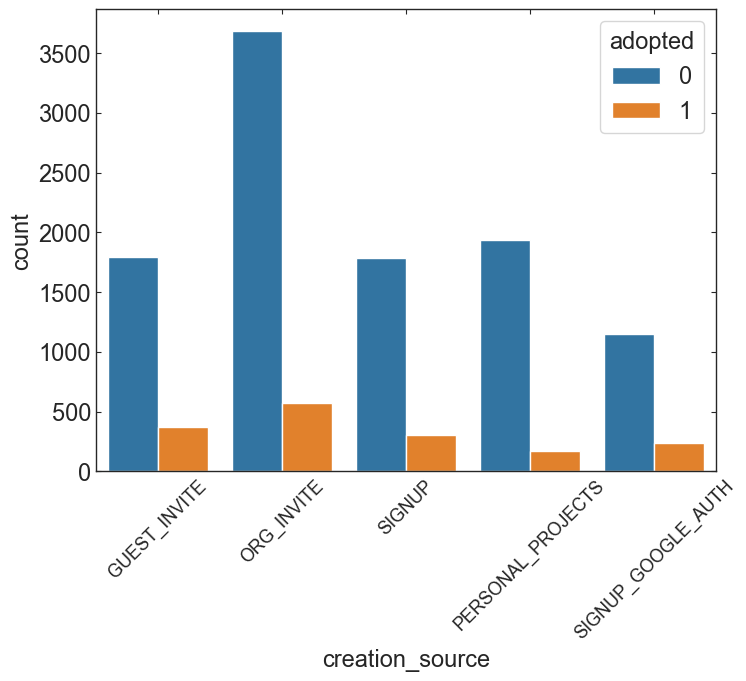

In [28]:
fig, ax = plt.subplots()

sns.countplot(x='creation_source', data=users, hue='adopted', ax=ax)

ax.tick_params(axis='x', rotation=45, labelsize=13);

> Users were signed up moslty as a full member of an orgianization. However, the number of non-adopted users is also large for this case. 

In [29]:
creation_list = users.creation_source.unique()

creation_list

array(['GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'PERSONAL_PROJECTS',
       'SIGNUP_GOOGLE_AUTH'], dtype=object)

In [30]:
adopt_rate_creation = {}

for icreate in creation_list:
    adopt_rate = users.loc[users.creation_source==icreate, 'adopted'].mean()
    adopt_rate_creation[icreate] = [adopt_rate]

df_adopt_rate_creation = pd.DataFrame(adopt_rate_creation, index=['adopt_rate']).T

df_adopt_rate_creation

,adopt_rate
GUEST_INVITE,0.170596
ORG_INVITE,0.134932
SIGNUP,0.144705
PERSONAL_PROJECTS,0.081478
SIGNUP_GOOGLE_AUTH,0.172563


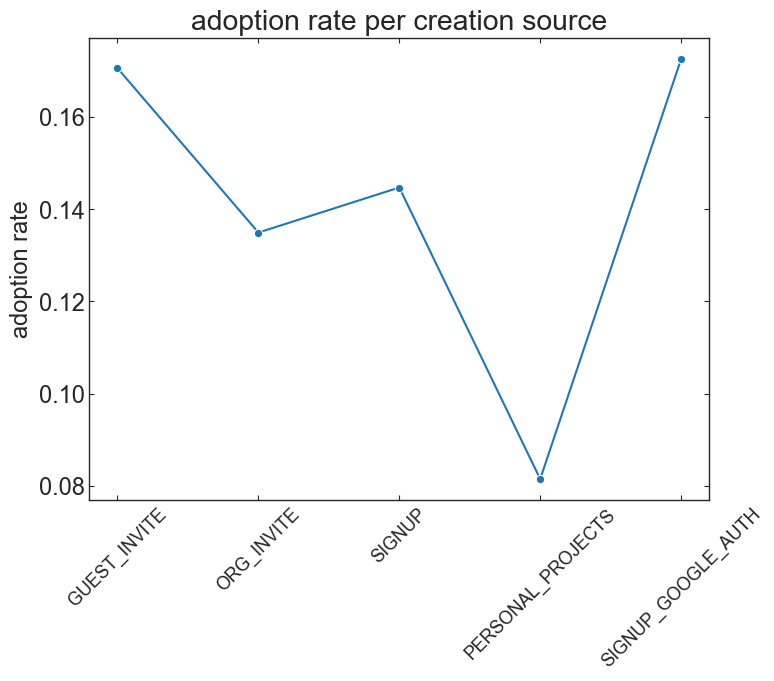

In [31]:
fig, ax = plt.subplots()

sns.lineplot(data=df_adopt_rate_creation, legend=None, marker='o', ax=ax)
ax.tick_params(axis='x', rotation=45, labelsize=13)
ax.set(title='adoption rate per creation source', ylabel='adoption rate');

> - The adoption rate is the highest when users are invited to an orgizniation a a guest, and the lowest when users are invited to join another user's personal workspace. 
> - Users who sign up using Google Authentication are very likely adopted. 

In [32]:
users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
object_id,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


## check adopted rate for opted into receving marketing emails

In [33]:
users.opted_in_to_mailing_list.value_counts()

0    9006
1    2994
Name: opted_in_to_mailing_list, dtype: int64

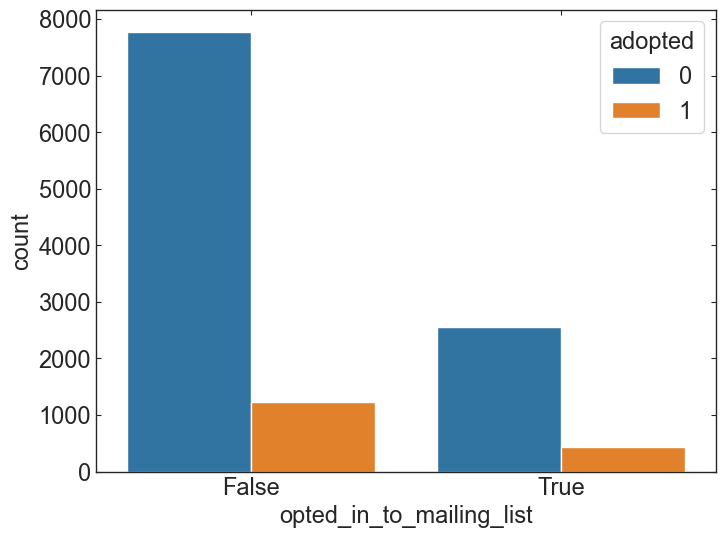

In [34]:
fig, ax = plt.subplots()

tick_label = {0:'False', 1:'True'}
sns.countplot(x='opted_in_to_mailing_list', data=users, hue='adopted', ax=ax)

ax.set_xticklabels([tick_label[i] for i in range(len(tick_label))]);
#ax.tick_params(axis='x', rotation=45, labelsize=13);

In [35]:
adopt_rate_optedmail = {}

for iopt in [0,1]:
    adopt_rate = users.loc[users.opted_in_to_mailing_list==iopt, 'adopted'].mean()
    adopt_rate_optedmail[iopt] = [adopt_rate]

df_adopt_rate_optedmail = pd.DataFrame(adopt_rate_optedmail, index=['adopt_rate'])

df_adopt_rate_optedmail

,0,1
adopt_rate,0.136243,0.143287


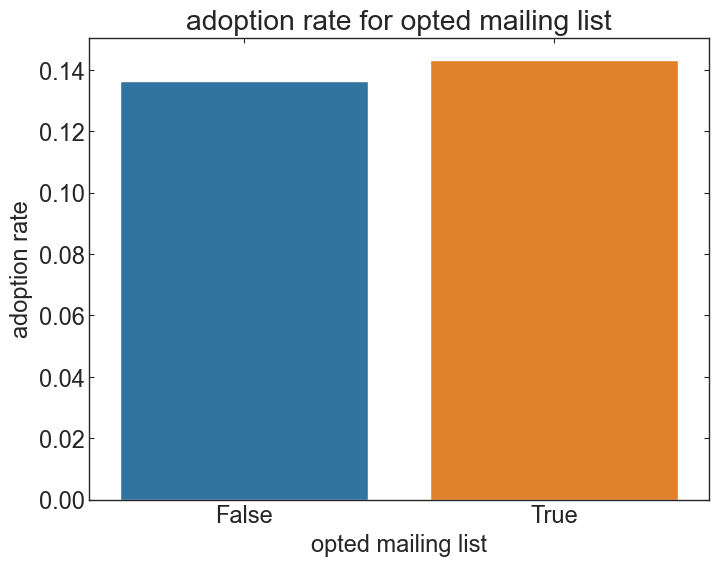

In [36]:
fig, ax = plt.subplots()

tick_label = {0:'False', 1:'True'}
sns.barplot(data=df_adopt_rate_optedmail, ax=ax)

ax.set_xticklabels([tick_label[i] for i in range(len(tick_label))])

ax.set(title='adoption rate for opted mailing list', \
       xlabel='opted mailing list', ylabel='adoption rate');

> The adoption rate is slightly increased when the users have opted into receiving marketing emails.

## check adopted rate for regular marketing emails

In [37]:
users.enabled_for_marketing_drip.value_counts()

0    10208
1     1792
Name: enabled_for_marketing_drip, dtype: int64

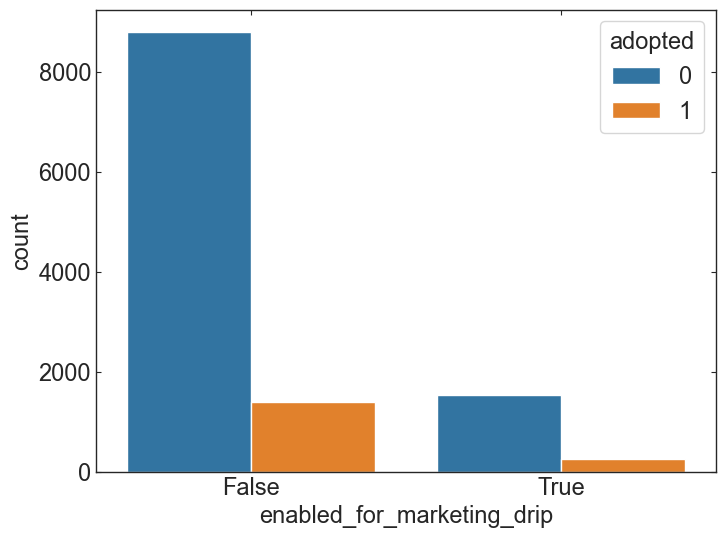

In [38]:
fig, ax = plt.subplots()

tick_label = {0:'False', 1:'True'}
sns.countplot(x='enabled_for_marketing_drip', data=users, hue='adopted', ax=ax);

ax.set_xticklabels([tick_label[i] for i in range(len(tick_label))]);

In [39]:
adopt_rate_marketing= {}

for imark in [0,1]:
    adopt_rate = users.loc[users.enabled_for_marketing_drip==imark, 'adopted'].mean()
    adopt_rate_marketing[imark] = [adopt_rate]

df_adopt_rate_marketing = pd.DataFrame(adopt_rate_marketing, index=['adopt_rate'])

df_adopt_rate_marketing

,0,1
adopt_rate,0.137049,0.143415


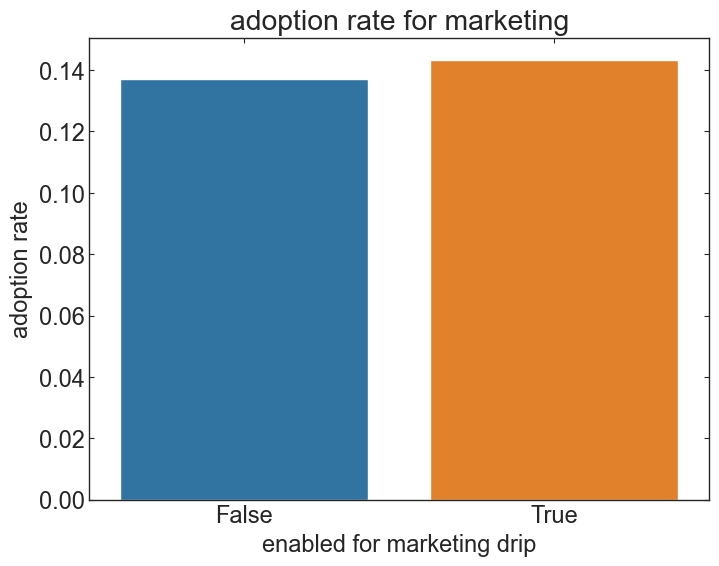

In [40]:
fig, ax = plt.subplots()

tick_label = {0:'False', 1:'True'}
sns.barplot(data=df_adopt_rate_marketing, ax=ax)

ax.set_xticklabels([tick_label[i] for i in range(len(tick_label))])

ax.set(title='adoption rate for marketing', \
       xlabel='enabled for marketing drip', ylabel='adoption rate');

> The adoption rate is slightly increased when the users are on the regular markketing email drip.

# Feature Engineering

## add additional features

In [41]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   name                        12000 non-null  object        
 2   email                       12000 non-null  object        
 3   creation_source             12000 non-null  object        
 4   last_session_creation_time  12000 non-null  datetime64[ns]
 5   opted_in_to_mailing_list    12000 non-null  int64         
 6   enabled_for_marketing_drip  12000 non-null  int64         
 7   org_id                      12000 non-null  int64         
 8   invited_by_user_id          12000 non-null  float64       
 9   adopted                     12000 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 1.0+ MB


In [42]:
''' add features 
      - active_time: how long the users are active   (days)
      - account_time: how long since the users were signed up  (days)
'''
users['active_time'] = (users.last_session_creation_time - users.creation_time).dt.days
users['account_time'] = (users.creation_time.max() - users.creation_time).dt.days
users[['creation_time','last_session_creation_time','active_time','account_time']]

,creation_time,last_session_creation_time,active_time,account_time
object_id,,,,
1,2014-04-22 03:53:30,2014-04-22 03:53:30,0,38
2,2013-11-15 03:45:04,2014-03-31 03:45:04,136,196
3,2013-03-19 23:14:52,2013-03-19 23:14:52,0,437
4,2013-05-21 08:09:28,2013-05-22 08:09:28,1,374
5,2013-01-17 10:14:20,2013-01-22 10:14:20,5,498
...,...,...,...,...
11996,2013-09-06 06:14:15,2013-09-06 06:14:15,0,266
11997,2013-01-10 18:28:37,2013-01-15 18:28:37,5,505
11998,2014-04-27 12:45:16,2014-04-27 12:45:16,0,33


In [43]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   name                        12000 non-null  object        
 2   email                       12000 non-null  object        
 3   creation_source             12000 non-null  object        
 4   last_session_creation_time  12000 non-null  datetime64[ns]
 5   opted_in_to_mailing_list    12000 non-null  int64         
 6   enabled_for_marketing_drip  12000 non-null  int64         
 7   org_id                      12000 non-null  int64         
 8   invited_by_user_id          12000 non-null  float64       
 9   adopted                     12000 non-null  int64         
 10  active_time                 12000 non-null  int64         
 11  account_time                12000 non-null  int64     

In [44]:
''' drop the redundant features '''
users_final = users.drop(columns=['creation_time','name','email', \
                                  'last_session_creation_time','org_id', \
                                  'invited_by_user_id'])

users_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   creation_source             12000 non-null  object
 1   opted_in_to_mailing_list    12000 non-null  int64 
 2   enabled_for_marketing_drip  12000 non-null  int64 
 3   adopted                     12000 non-null  int64 
 4   active_time                 12000 non-null  int64 
 5   account_time                12000 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 656.2+ KB


## one-hot encoding for categorical features

In [45]:
df = pd.get_dummies(users_final, columns=['creation_source'], drop_first=True,\
                   prefix='source')

In [46]:
df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted,active_time,account_time,source_ORG_INVITE,source_PERSONAL_PROJECTS,source_SIGNUP,source_SIGNUP_GOOGLE_AUTH
object_id,,,,,,,,,
1,1,0,0,0,38,0,0,0,0
2,0,0,1,136,196,1,0,0,0
3,0,0,0,0,437,1,0,0,0
4,0,0,0,1,374,0,0,0,0
5,0,0,0,5,498,0,0,0,0


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   opted_in_to_mailing_list    12000 non-null  int64
 1   enabled_for_marketing_drip  12000 non-null  int64
 2   adopted                     12000 non-null  int64
 3   active_time                 12000 non-null  int64
 4   account_time                12000 non-null  int64
 5   source_ORG_INVITE           12000 non-null  uint8
 6   source_PERSONAL_PROJECTS    12000 non-null  uint8
 7   source_SIGNUP               12000 non-null  uint8
 8   source_SIGNUP_GOOGLE_AUTH   12000 non-null  uint8
dtypes: int64(5), uint8(4)
memory usage: 609.4 KB


## Imbalanced Classification
- either of under-sampling or SMOTE methods

In [48]:
adopted_count = dict(Counter(df.adopted))

print(adopted_count)
print('adopted rate: {}%'.format(adopted_count[1]/(adopted_count[0]+adopted_count[1])))

{0: 10344, 1: 1656}
adopted rate: 0.138%


> The users dataset is highly imbalanced that non-adopted users are dominant.

In [68]:
# instantiating the SMOTE resampler
smt = SMOTE()

# resampling X, y
X_resmp, y_resmp = smt.fit_resample(df.drop(columns=['adopted']), df.adopted)

# new class distribution 
print(Counter(y_resmp))

Counter({0: 10344, 1: 10344})


## check correlation between features
- remove features in multicollinearity by evaluating Variation Inflation Factor (VIF)

In [69]:
corr = X_resmp.corr()

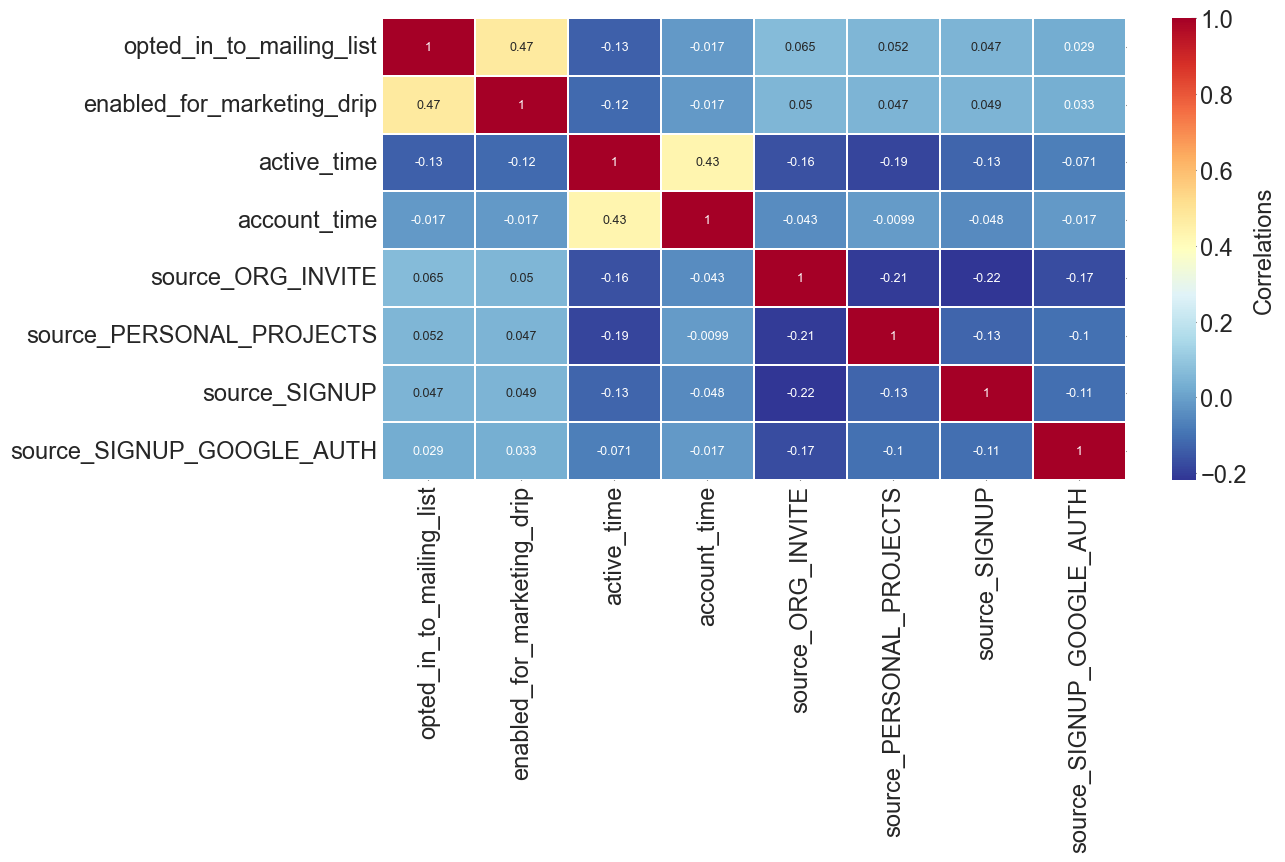

In [70]:
fig, ax = plt.subplots(figsize=(12,6))

sns.heatmap(corr, linewidth=.1, annot=True, annot_kws={"size":9}, cmap="RdYlBu_r", 
            cbar_kws={'label':'Correlations'}, ax=ax);

In [71]:
def calc_vif(X):
    ''' Calculating Variance Inflation Factor (VIF)
        args:
            X: input dataframe
        return:
            dataframe that contains VIF values
    '''
    vif = pd.DataFrame()
    vif["features"] = X.columns
    vif["VIFactor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [72]:
vif = calc_vif(X_resmp)
vif.sort_values(by='VIFactor', ascending=False)

,features,VIFactor
3,account_time,3.167620
2,active_time,2.088956
0,opted_in_to_mailing_list,1.561686
1,enabled_for_marketing_drip,1.438057
4,source_ORG_INVITE,1.375016
5,source_PERSONAL_PROJECTS,1.209880
6,source_SIGNUP,1.166980
7,source_SIGNUP_GOOGLE_AUTH,1.111059


> It appears that all variables are not likely correlated to each other. 

## Split data into training and test sets

In [73]:
X = X_resmp
y = y_resmp

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

In [75]:
print('Shape of training set: {}'.format(X_train.shape))
print('Shape of test set: {}'.format(X_test.shape))

Shape of training set: (14481, 8)
Shape of test set: (6207, 8)


## Scaling

In [76]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Build a predictive model

## RandomForest: Hyperparameter tuning

In [77]:
model_randf = RandomForestClassifier(random_state=23)
kf = KFold(n_splits=6, shuffle=True, random_state=23)

# Create the parameter space
params = {'n_estimators': [int(x) for x in np.linspace(10,100,10)], # number of trees
          'criterion': ['gini', 'entropy'], # measure the quality of a split
          'max_features': ['auto', 'sqrt'], # The number of features to consider
          'max_depth': [2, 4, None], # maximum depth of the tree
          'min_samples_split': [2, 5], # minimum number of samples to split an internal node
          'min_samples_leaf': [1, 2], # minimum number of samples required to be a leaf node
          'bootstrap': [True, False]} # whether bootstrap samples are used when building trees

# Instantiate the RandomizedSearchCV object
randf_cv = RandomizedSearchCV(model_randf, params, cv=kf, scoring='roc_auc', error_score='raise')

# Fit the data to the model
randf_cv.fit(X_train_scaled, y_train)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters:")
print(randf_cv.best_params_)
print("*"*30)
print("Tuned Random Forest Best Accuracy Score: {}".format(randf_cv.best_score_))

Tuned Random Forest Parameters:
{'n_estimators': 90, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}
******************************
Tuned Random Forest Best Accuracy Score: 0.9957761312178217


## Build a model with best parameters

In [78]:
model_randf= RandomForestClassifier(random_state=23, **randf_cv.best_params_)

model_randf.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=False, min_samples_split=5, n_estimators=90,
                       random_state=23)

In [79]:
# model predict
y_pred_randf = model_randf.predict(X_test_scaled)

# predict probabilities
y_pred_probs_randf = model_randf.predict_proba(X_test_scaled)[:,1]

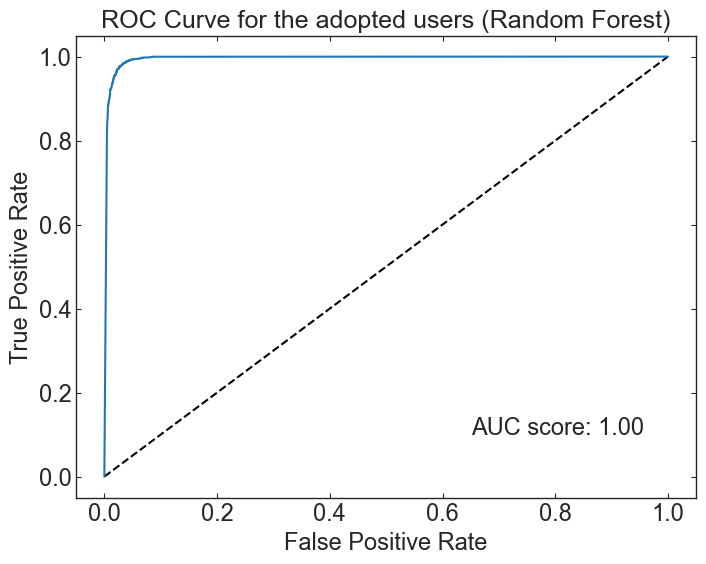

In [80]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr_randf, tpr_randf, thresholds = roc_curve(y_test, y_pred_probs_randf)

fig, ax = plt.subplots()

ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr_randf, tpr_randf)
ax.annotate('AUC score: {:.2f}'.format(roc_auc_score(y_test, y_pred_probs_randf)), \
           xy=(0.65,0.1), xycoords='data',ha='left')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for the adopted users (Random Forest)', fontsize=18);

> The model shows very nice performance. 

In [81]:
# Calculate roc_auc_score
randf_best_score = roc_auc_score(y_test, y_pred_probs_randf)
print("ROC AUC score: {:.2f}".format(randf_best_score))

# Calculate the confusion matrix
print("*"*10 + "  Confusion Matrix  " + "*"*10)
print(confusion_matrix(y_test, y_pred_randf))

# Calculate the classification report
print("*"*10 + "  Classification Report  " + "*"*10)
print(classification_report(y_test, y_pred_randf))

ROC AUC score: 1.00
**********  Confusion Matrix  **********
[[2938   96]
 [  62 3111]]
**********  Classification Report  **********
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3034
           1       0.97      0.98      0.98      3173

    accuracy                           0.97      6207
   macro avg       0.97      0.97      0.97      6207
weighted avg       0.97      0.97      0.97      6207



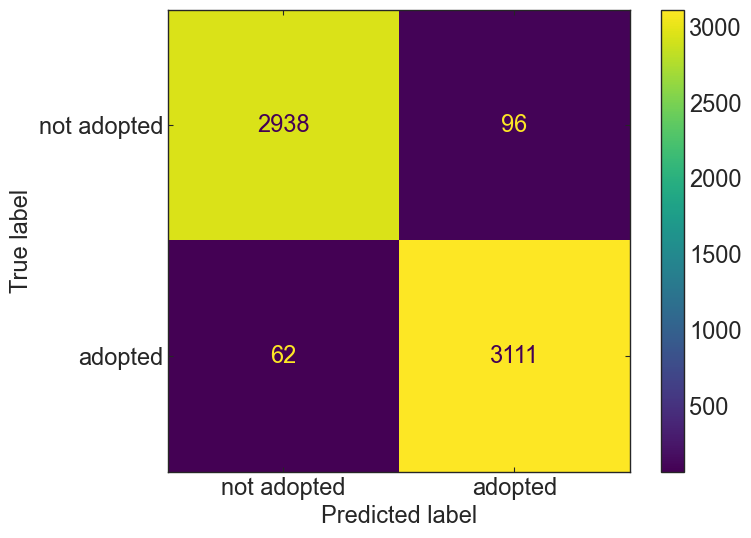

In [83]:
''' plot the confusion matrix '''
cm = confusion_matrix(y_test, y_pred_randf, labels = model_randf.classes_)
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['not adopted', 'adopted'])
fig, ax = plt.subplots()
display_cm.plot(ax=ax);

# Importance of features

In [84]:
fi_dict = {'feature':X.columns, 'Importance':model_randf.feature_importances_}
df_fi = pd.DataFrame(fi_dict)

df_fi = df_fi.sort_values(by='Importance', ascending=False)
df_fi

,feature,Importance
2,active_time,0.830965
3,account_time,0.056389
5,source_PERSONAL_PROJECTS,0.036664
4,source_ORG_INVITE,0.024815
6,source_SIGNUP,0.021227
7,source_SIGNUP_GOOGLE_AUTH,0.012676
0,opted_in_to_mailing_list,0.011250
1,enabled_for_marketing_drip,0.006013


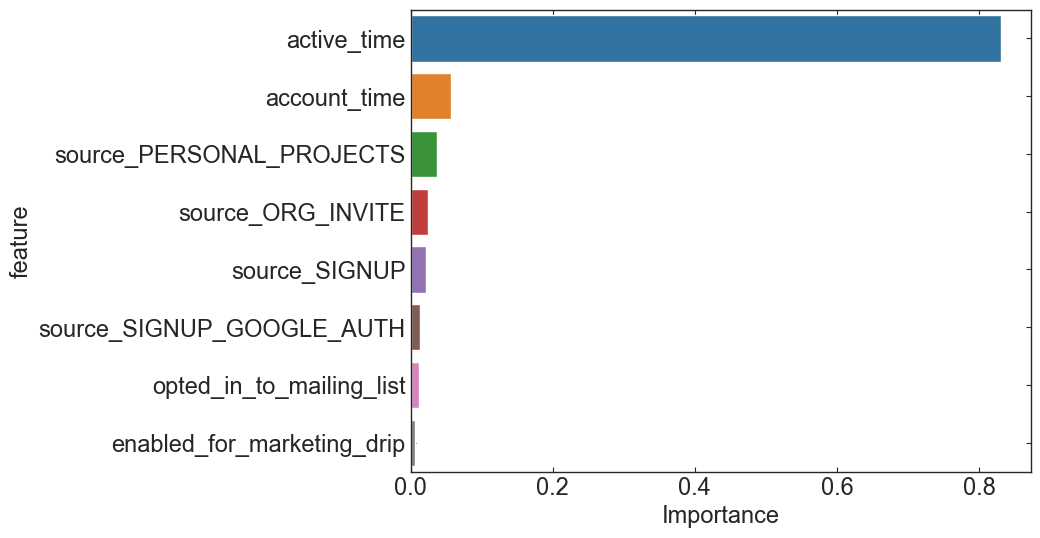

In [85]:
fig, ax = plt.subplots()

sns.barplot(x='Importance', y='feature', data=df_fi, ax=ax);

> active time is the most critical feature to evaluate the adoption of users. 

## SHAP Analysis

In [86]:
# Fits the explainer
explainer = shap.Explainer(model_randf.predict, X_test_scaled)

# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test_scaled)

# if only interested in the SHAP values: 
#shap_values = explainer.shap_values(X_test_scaled)

# rename the features (since the feature names were removed in the scaled data)
shap_values.feature_names = X_test.columns.values.tolist()

Exact explainer: 6208it [05:04, 19.89it/s]                                                                                      


In [90]:
''' save SHAP results for later usage '''

with open(os.path.join(datadir_pr,'shap_user.pkl'), "wb") as file:
    pickle.dump(shap_values, file)

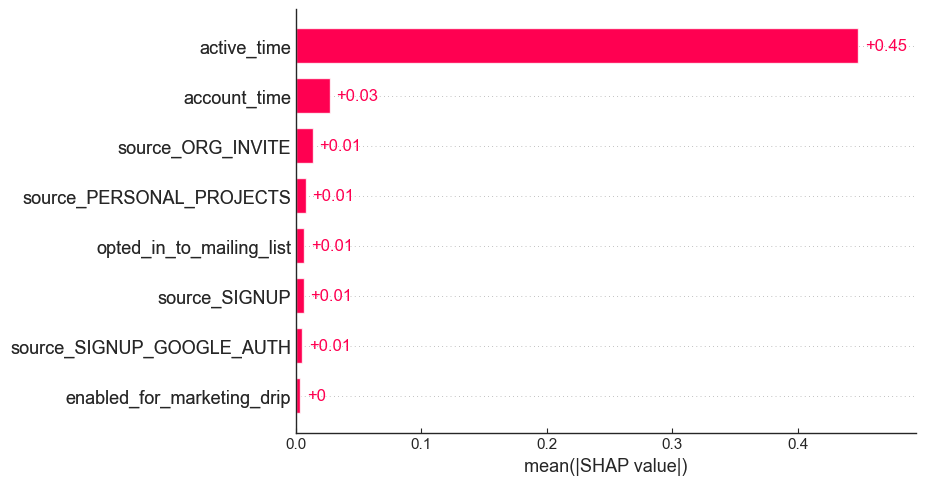

In [91]:
shap.plots.bar(shap_values);

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


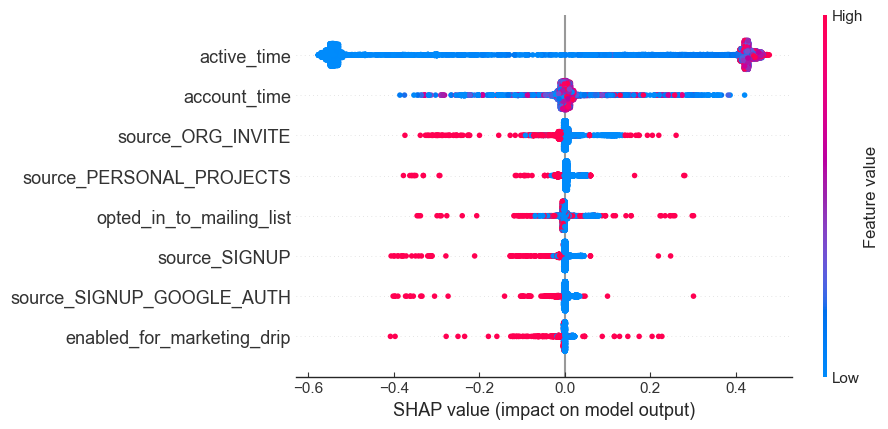

In [92]:
shap.plots.beeswarm(shap_values);

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


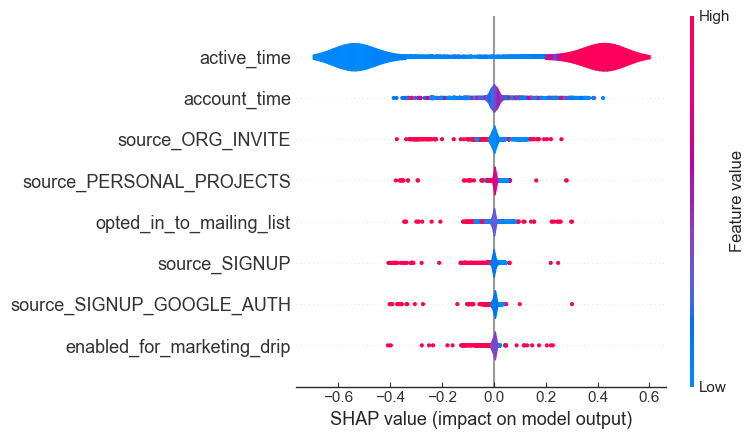

In [93]:
shap.summary_plot(shap_values, plot_type='violin');

# Suggestions
- It is obvious that 
    - active time is ciritical to evaluate the adoption of users. 
    - account time is also of importance. 
    
- I recommend that to increase the number of adopted users, the organization needs to encourage existing users to log in and try using programs even though they opened the account for a while ago.  